In [78]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

In [91]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

## Exploratory Analysis

In [64]:
import pandas as pd
predictive_maintenance = pd.read_csv("data/predictive_maintenance.csv")
predictive_maintenance.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/15,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,1/1/15,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/15,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/15,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/15,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [65]:
predictive_maintenance.groupby('failure').count()

,date,device,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
failure,,,,,,,,,,,
0,124388,124388,124388,124388,124388,124388,124388,124388,124388,124388,124388
1,106,106,106,106,106,106,106,106,106,106,106


We have a major class imbalance.

In [2]:
predictive_maintenance.describe()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [3]:
predictive_maintenance.device.describe()

count       124494
unique        1169
top       Z1F0QLC1
freq           304
Name: device, dtype: object

In [30]:
predictive_maintenance.corr()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
failure,1.000000,0.001983,0.052902,-0.000948,0.067398,0.002270,-0.000550,0.119055,0.119055,0.001622
metric1,0.001983,1.000000,-0.004250,0.003701,0.001836,-0.003376,-0.001522,0.000151,0.000151,0.001121
metric2,0.052902,-0.004250,1.000000,-0.002617,0.146593,-0.013999,-0.026350,0.141367,0.141367,-0.002736
metric3,-0.000948,0.003701,-0.002617,1.000000,0.097452,-0.006696,0.009027,-0.001884,-0.001884,0.532366
metric4,0.067398,0.001836,0.146593,0.097452,1.000000,-0.009773,0.024870,0.045631,0.045631,0.036069
metric5,0.002270,-0.003376,-0.013999,-0.006696,-0.009773,1.000000,-0.017049,-0.009384,-0.009384,0.005949
metric6,-0.000550,-0.001522,-0.026350,0.009027,0.024870,-0.017049,1.000000,-0.012207,-0.012207,0.021152
metric7,0.119055,0.000151,0.141367,-0.001884,0.045631,-0.009384,-0.012207,1.000000,1.000000,0.006861
metric8,0.119055,0.000151,0.141367,-0.001884,0.045631,-0.009384,-0.012207,1.000000,1.000000,0.006861
metric9,0.001622,0.001121,-0.002736,0.532366,0.036069,0.005949,0.021152,0.006861,0.006861,1.000000


In [31]:
predictive_maintenance.metric7.unique()

array([  0,  16,   8,  48,  32, 312,   6,  24,  40,  56,  96, 112, 136,
       152, 424, 240, 496, 744, 216,  72,  80, 176, 832, 128, 272, 736,
        22, 104], dtype=int64)

In [32]:
predictive_maintenance.metric8.unique()

array([  0,  16,   8,  48,  32, 312,   6,  24,  40,  56,  96, 112, 136,
       152, 424, 240, 496, 744, 216,  72,  80, 176, 832, 128, 272, 736,
        22, 104], dtype=int64)

There are two notable things. We have an imbalanced dataset and metric7 and metric8 seem to be repeated columns. 

## Model Development

### Data Prep

In [96]:
from sklearn.model_selection import train_test_split
feature_cols = ['metric1','metric2','metric3','metric4','metric5','metric6','metric7','metric9']
X = predictive_maintenance[feature_cols]
y = predictive_maintenance.failure
# summarize class distribution
print("Original: " + str(Counter(y)))
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
# summarize class distribution
print("Oversampled: " + str(Counter(y_over)))

Original: Counter({0: 124388, 1: 106})
Oversampled: Counter({0: 124388, 1: 124388})


In [73]:
X_train,X_test,y_train,y_test=train_test_split(X_over,y_over,test_size=0.20,random_state=0)

### Logistic Regression

In [74]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression() #using l2 regularization by default 
logisticRegr.fit(X_train, y_train)

LogisticRegression()

In [75]:
logisticRegr.score(X_test, y_test)

0.6613071790336844

In [76]:
y_pred = logisticRegr.predict(X_test)

In [83]:
probs = logisticRegr.predict_proba(X_test)
probs = probs[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, probs)

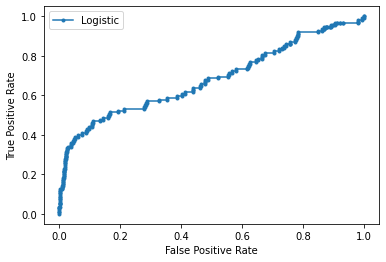

In [84]:
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [85]:
lr_auc = roc_auc_score(y_test, probs)
lr_auc

0.6821959288020021

In [86]:
logisticRegr.predict(X_test)

array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

In [90]:
from sklearn.metrics import recall_score
tpr = recall_score(y_test, y_pred)
tnr = recall_score(y_test, y_pred, pos_label = 0) 
fpr = 1 - tnr
fnr = 1 - tpr
print("False Positive Rate: " + str(fpr))
print("False Negative Rate: " + str(fnr))

False Positive Rate: 0.08679396984924626
False Negative Rate: 0.5905309272135364


### Decision Tree

In [99]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [100]:
dt.score(X_test, y_test)

0.9997186268992684

In [101]:
y_pred = dt.predict(X_test)

In [103]:
probs = dt.predict_proba(X_test)
probs = probs[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, probs)

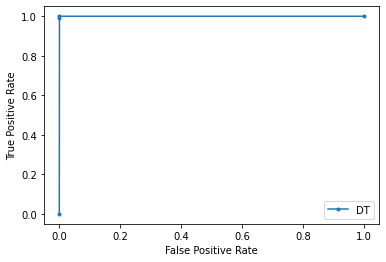

In [104]:
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='DT')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [105]:
lr_auc = roc_auc_score(y_test, probs)
lr_auc

0.9997160708086068

In [106]:
dt.predict(X_test)

array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

In [107]:
from sklearn.metrics import recall_score
tpr = recall_score(y_test, y_pred)
tnr = recall_score(y_test, y_pred, pos_label = 0) 
fpr = 1 - tnr
fnr = 1 - tpr
print("False Positive Rate: " + str(fpr))
print("False Negative Rate: " + str(fnr))

False Positive Rate: 0.000562814070351747
False Negative Rate: 0.0


### Notes

A bit suspicious of the incredible performance we see here from the decision tree classifier. Concerned that it might be overfitting. As such, some additional steps that would need to be taken would include:
    - Cross Validation to be done on both LR and DT models
    - Validation Curve to help us determine the relationship between test error and validation error to see if we are potentially overfitting

For the sake of time, will stick to this model for deployment/discussion.

## Save Model

In [108]:
import pickle
file_to_store = open("app/model.pickle", "wb")
pickle.dump(dt, file_to_store)
file_to_store.close()

In [109]:
with open("app/model.pickle", 'rb') as f:
    x = pickle.load(f)